In [ ]:
#| default_exp chewc2

In [ ]:
#| export

import torch
import matplotlib.pyplot as plt
from fastcore.basics import patch
import uuid
import pdb
import torch
from matplotlib.animation import FuncAnimation

device='cpu'

class Genome:
    def __init__(self, n_chr, n_loci):
        self.ploidy = 2
        self.n_chr = n_chr
        self.n_loci = n_loci
        self.shape = (self.ploidy, self.n_chr, self.n_loci)
        
class Population:
    def __init__(self, genome, haplotypes, device=device):
        self.genome = genome
        self.device = device
        self.phenotypes = None
        self.haplotypes = haplotypes
        self.dosages = haplotypes.sum(dim=1).float()
                
class Trait:
    def __init__(self, genome, founder_population, target_mean, target_variance, device=device):
        self.target_mean = target_mean
        self.target_variance = target_variance
        self.device = device
        random_effects = torch.randn(genome.n_chr, genome.n_loci, device=self.device)
        random_effects -= random_effects.mean()
        founder_scores = torch.einsum('kl,hkl->h', random_effects, founder_population.dosages)
        founder_mean, founder_var = founder_scores.mean(), founder_scores.var()
        scaling_factors = torch.sqrt(self.target_variance / founder_var)
        self.scaling_factors = scaling_factors
        random_effects *= scaling_factors
        self.effects = random_effects
        self.intercept = founder_mean - target_mean

        
def calculate_breeding_value(population_dosages, trait_effects, device = device):
    return torch.einsum('hjk,jk->h', population_dosages,trait_effects)

def truncation_selection(population, trait, top_percent):
    return torch.topk(population.phenotypes, top_percent).indices

# meiosis
def recombine(parent_haplo_tensor, recombination_rate=0.1):
    num_individuals, ploidy, num_chromosomes, num_loci = parent_haplo_tensor.shape    
    # Generate crossover masks
    maternal, paternal = parent_haplo_tensor[:,0,:,:],parent_haplo_tensor[:,1,:,:],
    crossovers = torch.bernoulli(torch.full((num_individuals, num_chromosomes, num_loci), recombination_rate, device=device))
    #crossovers = torch.rand((num_individuals, num_chromosomes, num_loci), device=device) < recombination_rate
    progeny = maternal * (1 - crossovers) + paternal * crossovers
    return progeny


def phenotype(population, trait, h2):
    breeding_values = calculate_breeding_value(population.dosages, trait.effects) 
    if breeding_values.var() == 0:
        print('phenotype: no var')
        environmental_variance = 0  
    else:
        environmental_variance = (1 - h2) / h2 * breeding_values.var() 
    environmental_noise = torch.randn(breeding_values.shape, device=device) * torch.sqrt(environmental_variance.clone().detach())
    population.phenotypes = breeding_values + environmental_noise

#     def _create_random_haplotypes(self,num_individuals):
#         return torch.randint(0, 2, (num_individuals, *self.g.shape), device=self.device)
def create_random_pop(G, pop_size):
    return torch.randint(0, 2, (pop_size, *G.shape), device= device)

def update_pop(population, haplotype_pop_tensor):
    population.haplotypes = haplotype_pop_tensor
    population.dosages = haplotype_pop_tensor.sum(dim=1).float()
    return population

# meiosis
def recombine(parent_haplo_tensor, recombination_rate=0.1):
    num_individuals, ploidy, num_chromosomes, num_loci = parent_haplo_tensor.shape
    # Generate crossover masks
    maternal, paternal = parent_haplo_tensor[:,0,:,:],parent_haplo_tensor[:,1,:,:],
    crossovers = torch.bernoulli(torch.full((num_individuals, num_chromosomes, num_loci), recombination_rate, device=device))
#     crossovers = torch.rand((num_individuals, num_chromosomes, num_loci), device=device) < recombination_rate
    progeny = maternal * torch.logical_not(crossovers) + paternal * crossovers
    return progeny

def breed(mother_tensor, father_tensor, recombination_rate=0.1):
    eggs = recombine(mother_tensor,recombination_rate)
    pollens = recombine(father_tensor,recombination_rate)
    return torch.stack((eggs,pollens), dim=1)

def create_pop(G, haplotypes):
    return Population(G, haplotypes=haplotypes)

def bv(P,T):
    P.breeding_values = calculate_breeding_value(P.dosages,T.effects)
    
def create_progeny(mother_gametes, father_gametes,reps = 1):
    progeny = []
    for _ in range(reps):
        # Randomly shuffle the gametes from each parent 
        shuffled_mother_indices = torch.randperm(mother_gametes.shape[0])
        shuffled_father_indices = torch.randperm(father_gametes.shape[0])

        # Select the shuffled gametes
        mother_gametes = mother_gametes[shuffled_mother_indices]
        father_gametes = father_gametes[shuffled_father_indices]

        # Stack the gametes to create progeny haplotypes
        progeny_haplotypes = torch.stack((mother_gametes, father_gametes),dim=1)
        progeny.append(progeny_haplotypes)
    return torch.vstack(progeny)

# Function to run one generation
def run_generation(P, T, h2, reps, pop_size, selection_fraction):
    bv(P, T)  # Calculate breeding values
    phenotype(P, T, h2)  # Calculate phenotypes with given h2
    selected = P.haplotypes[torch.topk(P.phenotypes, int(pop_size * selection_fraction)).indices]  # Select top individuals based on phenotype
    m = recombine(selected)  # Mother gametes
    f = recombine(selected)  # Father gametes
    progeny = create_progeny(m, f, reps=reps)  # Create progeny
    new_population = Population(G, progeny)
    bv(new_population, T)  # Calculate breeding values for progeny
    phenotype(new_population, T, h2)  # Calculate phenotypes for progeny
    return new_population

In [ ]:

# Parameters
pop_size = 200
h2 = 0.99
reps = 5
num_generations = 20

# Initialize genome and founder population
G = Genome(1, 1000)
P = create_pop(G, create_random_pop(G, pop_size))
T = Trait(G, P, 0, 1)

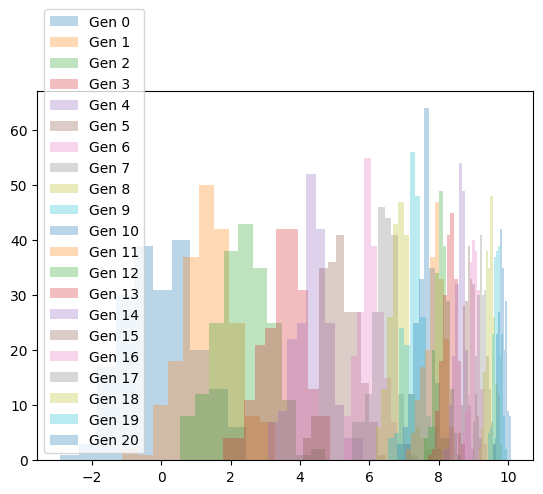

In [ ]:


# Parameters
pop_size = 200
h2 = 0.99
reps = 5
num_generations = 20

# Initialize genome and founder population
G = Genome(1, 1000)
P = create_pop(G, create_random_pop(G, pop_size))
T = Trait(G, P, 0, 1)

# Store populations for plotting
pops = [P]

# Run multiple generations
for generation in range(num_generations):
    P = run_generation(P, T, h2, reps, pop_size, selection_fraction=1/reps)
    pops.append(P)

# Plot phenotypes for each generation
for i, P in enumerate(pops):
    plt.hist(P.phenotypes, alpha=0.3, label=f'Gen {i}')

plt.legend()

plt.show()

In [ ]:
import torch
import matplotlib.pyplot as plt
from fastcore.basics import patch
import uuid
import pdb
import torch
from matplotlib.animation import FuncAnimation

device='cpu'

class Genome:
    def __init__(self, n_chr, n_loci):
        self.ploidy = 2
        self.n_chr = n_chr
        self.n_loci = n_loci
        self.shape = (self.ploidy, self.n_chr, self.n_loci)
        
class Population:
    def __init__(self, genome, haplotypes, device=device):
        self.genome = genome
        self.device = device
        self.haplotypes = haplotypes
        self.dosages = haplotypes.sum(dim=1).float()
        self.phenotypes = None
        self.breeding_values = None
                
class Trait:
    def __init__(self, genome, founder_population, target_mean, target_variance, device=device):
        self.target_mean = target_mean
        self.target_variance = target_variance
        self.device = device
        random_effects = torch.randn(genome.n_chr, genome.n_loci, device=self.device)
        random_effects -= random_effects.mean()
        founder_scores = torch.einsum('kl,hkl->h', random_effects, founder_population.dosages)
        founder_mean, founder_var = founder_scores.mean(), founder_scores.var()
        scaling_factors = torch.sqrt(self.target_variance / founder_var)
        self.scaling_factors = scaling_factors
        random_effects *= scaling_factors
        self.effects = random_effects
        self.intercept = founder_mean - target_mean

        
def calculate_breeding_value(population_dosages, trait_effects, device = device):
    return torch.einsum('hjk,jk->h', population_dosages,trait_effects)

def truncation_selection(population, trait, top_percent):
    return torch.topk(population.phenotypes, top_percent).indices

# meiosis
def recombine(parent_haplo_tensor, recombination_rate=0.1):
    num_individuals, ploidy, num_chromosomes, num_loci = parent_haplo_tensor.shape    
    # Generate crossover masks
    maternal, paternal = parent_haplo_tensor[:,0,:,:],parent_haplo_tensor[:,1,:,:],
    crossovers = torch.bernoulli(torch.full((num_individuals, num_chromosomes, num_loci), recombination_rate, device=device))
    #crossovers = torch.rand((num_individuals, num_chromosomes, num_loci), device=device) < recombination_rate
    progeny = maternal * (1 - crossovers) + paternal * crossovers
    return progeny


def phenotype(population, trait, h2):
    breeding_values = calculate_breeding_value(population.dosages, trait.effects) 
    if breeding_values.var() == 0:
        print('phenotype: no var')
        environmental_variance = 0  
    else:
        environmental_variance = (1 - h2) / h2 * breeding_values.var() 
    environmental_noise = torch.randn(breeding_values.shape, device=device) * torch.sqrt(environmental_variance.clone().detach())
    population.phenotypes = breeding_values + environmental_noise

#     def _create_random_haplotypes(self,num_individuals):
#         return torch.randint(0, 2, (num_individuals, *self.g.shape), device=self.device)
def create_random_pop(G, pop_size):
    return torch.randint(0, 2, (pop_size, *G.shape), device= device)

def update_pop(population, haplotype_pop_tensor):
    population.haplotypes = haplotype_pop_tensor
    population.dosages = haplotype_pop_tensor.sum(dim=1).float()
    return population

# meiosis
def recombine(parent_haplo_tensor, recombination_rate=0.1):
    num_individuals, ploidy, num_chromosomes, num_loci = parent_haplo_tensor.shape
    # Generate crossover masks
    maternal, paternal = parent_haplo_tensor[:,0,:,:],parent_haplo_tensor[:,1,:,:],
    crossovers = torch.bernoulli(torch.full((num_individuals, num_chromosomes, num_loci), recombination_rate, device=device))
#     crossovers = torch.rand((num_individuals, num_chromosomes, num_loci), device=device) < recombination_rate
    progeny = maternal * torch.logical_not(crossovers) + paternal * crossovers
    return progeny

def breed(mother_tensor, father_tensor, recombination_rate=0.1):
    eggs = recombine(mother_tensor,recombination_rate)
    pollens = recombine(father_tensor,recombination_rate)
    return torch.stack((eggs,pollens), dim=1)

def create_pop(G, haplotypes):
    return Population(G, haplotypes=haplotypes)

def bv(P,T):
    P.breeding_values = calculate_breeding_value(P.dosages,T.effects)
    
def create_progeny(mother_gametes, father_gametes,reps = 1):
    progeny = []
    for _ in range(reps):
        # Randomly shuffle the gametes from each parent 
        shuffled_mother_indices = torch.randperm(mother_gametes.shape[0])
        shuffled_father_indices = torch.randperm(father_gametes.shape[0])

        # Select the shuffled gametes
        mother_gametes = mother_gametes[shuffled_mother_indices]
        father_gametes = father_gametes[shuffled_father_indices]

        # Stack the gametes to create progeny haplotypes
        progeny_haplotypes = torch.stack((mother_gametes, father_gametes),dim=1)
        progeny.append(progeny_haplotypes)
    return torch.vstack(progeny)


Generation 1: Avg Phenotype = 1.18, Reward = 1.18
Generation 2: Avg Phenotype = 0.63, Reward = 0.63
Generation 3: Avg Phenotype = 1.03, Reward = 1.03
Generation 4: Avg Phenotype = 1.26, Reward = 1.26
Generation 5: Avg Phenotype = 1.20, Reward = 1.20
Generation 6: Avg Phenotype = 1.26, Reward = 1.26
Generation 7: Avg Phenotype = 1.52, Reward = 1.52
Generation 8: Avg Phenotype = 1.31, Reward = 1.31
Generation 9: Avg Phenotype = 1.66, Reward = 1.66
Generation 10: Avg Phenotype = 1.64, Reward = 1.64


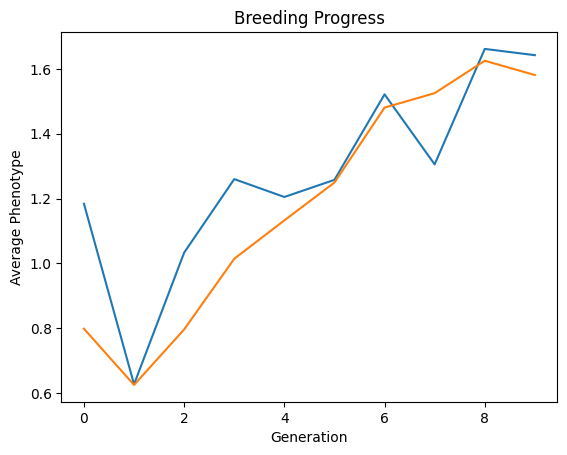

In [ ]:

class BreedingSimulation:
    def __init__(self, G, T, h2, reps, pop_size, selection_fraction):
        self.G = G
        self.T = T
        self.h2 = h2
        self.reps = reps
        self.pop_size = pop_size
        self.selection_fraction = selection_fraction
        self.population = create_pop(G, create_random_pop(G, pop_size)) # Start with a random population
        self.history = []  # For tracking population data over generations

    def step(self, actions): # Actions will be provided by the RL agent
        selected_parent_indices = self.select_parents(actions)
        selected = self.population.haplotypes[selected_parent_indices]
        
        #breeding
        m = recombine(selected)  # Mother gametes
        f = recombine(selected)  # Father gametes
        progeny = create_progeny(m, f, reps=self.reps)  # Create progeny

        #phenotype
        self.population = update_pop(self.population, progeny)
        bv(self.population, self.T)
        phenotype(self.population, self.T, self.h2)

        # Calculate reward (e.g., genetic gain)
        reward = self.calculate_reward()

        # Track data for this generation
        self.track_data(actions, reward)

        return self.get_state(), reward

    def select_parents(self, actions):
        #the output from agent network will go into here.
        phenotype(self.population, self.T, self.h2)
        parents = torch.topk(self.population.phenotypes, actions).indices
        return parents

    def calculate_reward(self):
        # Define how to calculate the reward based on your objective. 
        # Example: Improvement in average trait value
        return self.population.phenotypes.mean()

    def get_state(self):
        # Define how to represent the state of the environment to the 
        # RL agent. You might return features like:
        # - Average trait value: self.population.phenotypes.mean()
        # - Genetic diversity metrics
        # - ...
        return self.population.phenotypes.mean() # Placeholder

    def track_data(self, actions, reward):
        gen_data = {
            'generation': len(self.history),
            'avg_phenotype': self.population.phenotypes.mean().item(),
            'phenotype_variance': self.population.phenotypes.var().item(),
            'avg_breeding_value': self.population.breeding_values.mean().item(),
            'actions': actions,  # You might want to log the actions taken
            'reward': reward.item()
        }
        self.history.append(gen_data)

    def plot_history(self):
        generations = [d['generation'] for d in self.history]
        avg_phenotypes = [d['avg_phenotype'] for d in self.history]
        actions = [d['avg_breeding_value'] for d in self.history]
        plt.plot(generations, avg_phenotypes)
        plt.plot(generations, actions)
        plt.xlabel('Generation')
        plt.ylabel('Average Phenotype')
        plt.title('Breeding Progress')
        plt.show()

# --- Example Usage ---
G = Genome(n_chr=7, n_loci=1000)
founder_pop_size = 2
founder_pop = create_pop(G, create_random_pop(G, founder_pop_size))
T = Trait(G, founder_pop, target_mean=0.0, target_variance=1.0)

sim = BreedingSimulation(G, T, h2=0.2, reps=2, pop_size=200, selection_fraction=0.5)

# Simulate 10 generations (replace this with your RL training loop)
for generation in range(10):
    # Placeholder: Generate random actions (you'll use your RL agent's policy here)
    actions = 5
    state, reward = sim.step(actions) 
    print(f"Generation {generation+1}: Avg Phenotype = {state:.2f}, Reward = {reward:.2f}")

sim.plot_history()

In [ ]:
import torch
import torch.nn as nn

class BreedingCNN(nn.Module):
    def __init__(self, num_filters=64, kernel_size=32, stride=8, hidden_size=64,
                 num_tilings=10, tile_width=128): 
        super(BreedingCNN, self).__init__()

        # 1D Convolutional Layers (process each chromosome)
        self.conv1 = nn.Conv1d(in_channels=2,  # Diploidy
                               out_channels=num_filters, 
                               kernel_size=kernel_size, 
                               stride=stride)
        self.conv2 = nn.Conv1d(in_channels=num_filters, 
                               out_channels=num_filters // 4, # Reduce channels
                               kernel_size=kernel_size // 4,  # Smaller kernel
                               stride=stride // 2)          # Smaller stride

        # Flatten and Tile Coding
        self.flatten = nn.Flatten()
        self.tiling = nn.Linear(num_filters // 4 * (1000 // (stride * stride // 2)), 
                                  hidden_size * num_tilings)

        # Selection Head (output score for each individual)
        self.selection_head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(), 
            nn.Linear(hidden_size, 1) # Output score
        )

    def forward(self, x):
        batch_size, num_individuals, ploidy, chr_len, num_markers = x.shape

        # Reshape for 1D convolutions (combine ploidy and chr)
        x = x.view(batch_size * num_individuals * ploidy, chr_len, num_markers)

        # Convolutional Feature Extraction
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = self.flatten(x)

        # Tile Coding (for generalization and sparse representation)
        x = self.tiling(x)
        x = x.view(batch_size * num_individuals, num_tilings, hidden_size)
        x = torch.mean(x, dim=1) # Average across tilings

        # Selection Score 
        scores = self.selection_head(x)
        return scores.view(batch_size, num_individuals)  # Reshape to (batch, individuals)

In [ ]:
bc = BreedingCNN()

In [ ]:
sim.population.haplotypes.view(10, 2, -1).shape

torch.Size([10, 2, 7000])

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class GeneticFeatureExtractor(nn.Module):
    def __init__(self, input_size, num_features=64):
        super(GeneticFeatureExtractor, self).__init__()
        self.num_features = num_features
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=64, kernel_size=32, stride=8)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=16, kernel_size=8, stride=2)
        
        # Calculate the size after convolutions
        conv1_output_size = (input_size - 32) // 8 + 1
        conv2_output_size = (conv1_output_size - 8) // 2 + 1
        self.flattened_size = conv2_output_size * 16
        
        self.flatten = nn.Flatten()
        self.mlp = nn.Linear(self.flattened_size, self.num_features)

    def forward(self, x):
        x1 = self.conv1(x)
        x1 = torch.relu(x1)
        x1 = self.conv2(x1)
        x1 = torch.relu(x1)
        x1 = self.flatten(x1)
        x1 = self.mlp(x1)

        # Permute the channels
        x2 = x.flip(1)
        x2 = self.conv1(x2)
        x2 = torch.relu(x2)
        x2 = self.conv2(x2)
        x2 = torch.relu(x2)
        x2 = self.flatten(x2)
        x2 = self.mlp(x2)

        # Average the outputs
        x = (x1 + x2) / 2
        return x

# Function to create dummy data
def create_dummy_data(batch_size, channels, length):
    return torch.randn(batch_size, channels, length)

# Example usage with different input sizes
input_length = 7000  # Change this to any length
pop_size = 1
dummy_data = create_dummy_data(pop_size, 2, input_length)

# Instantiate the model with flexible input size
model = GeneticFeatureExtractor(input_length)
output = model(dummy_data)

print(output.shape)  # Expected output shape: (10, 64)

# Define a simple training loop for demonstration
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Dummy target data for demonstration purposes
target = torch.randn(pop_size, 64)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = model(dummy_data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")


torch.Size([1, 64])
Epoch 1/5, Loss: 1.1468873023986816
Epoch 2/5, Loss: 0.3812059760093689
Epoch 3/5, Loss: 0.1326318085193634
Epoch 4/5, Loss: 0.08100002259016037
Epoch 5/5, Loss: 0.08143432438373566


In [ ]:
import torch
import torch.nn as nn

class MetaDataProcessor(nn.Module):
    def __init__(self, num_features=64, meta_features=16):
        super(MetaDataProcessor, self).__init__()
        self.num_features = num_features
        self.meta_features = meta_features
        self.meta_mlp_action = nn.Linear(1, meta_features)  # Mapping for action network
        self.meta_mlp_value = nn.Linear(1, meta_features)  # Mapping for value network

    def forward(self, generation_percent):
        meta_action = self.meta_mlp_action(generation_percent)
        meta_value = self.meta_mlp_value(generation_percent)
        return meta_action, meta_value

    
    
class CompleteNetwork(nn.Module):
    def __init__(self, input_size, num_features=64, meta_features=16):
        super(CompleteNetwork, self).__init__()
        self.genetic_extractor = GeneticFeatureExtractor(input_size, num_features)
        self.meta_processor = MetaDataProcessor(num_features, meta_features)
        self.final_mlp_action = nn.Linear(num_features + meta_features, num_features)
        self.final_mlp_value = nn.Linear(num_features + meta_features, num_features)

    def forward(self, x, generation_percent):
        genetic_features = self.genetic_extractor(x)
        meta_action, meta_value = self.meta_processor(generation_percent)
        combined_action = torch.cat((genetic_features, meta_action), dim=1)
        combined_value = torch.cat((genetic_features, meta_value), dim=1)
        action_output = self.final_mlp_action(combined_action)
        value_output = self.final_mlp_value(combined_value)
        return action_output, value_output


In [ ]:
# Example usage with different input sizes
input_length = 7000  # Change this to any length
dummy_data = create_dummy_data(10, 2, input_length)
dummy_generation_percent = torch.rand(10, 1)  # Dummy generation percentage data

# Instantiate the model with flexible input size
model = CompleteNetwork(input_length)
action_output, value_output = model(dummy_data, dummy_generation_percent)

print(action_output.shape)  # Expected output shape: (10, 64)
print(value_output.shape)  # Expected output shape: (10, 64)

# Define a simple training loop for demonstration
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Dummy target data for demonstration purposes
target_action = torch.randn(10, 64)
target_value = torch.randn(10, 64)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    optimizer.zero_grad()
    action_output, value_output = model(dummy_data, dummy_generation_percent)
    loss_action = criterion(action_output, target_action)
    loss_value = criterion(value_output, target_value)
    loss = loss_action + loss_value
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")

torch.Size([10, 64])
torch.Size([10, 64])
Epoch 1/5, Loss: 2.0535287857055664
Epoch 2/5, Loss: 1.8783986568450928
Epoch 3/5, Loss: 1.7177562713623047
Epoch 4/5, Loss: 1.5365862846374512
Epoch 5/5, Loss: 1.378826379776001


In [ ]:
model(sim.population.haplotypes.view(10, 2, -1), dummy_generation_percent)[0].shape

torch.Size([10, 64])

In [ ]:
model(sim.population.haplotypes.view(10, 2, -1), dummy_generation_percent)[1].shape

torch.Size([10, 64])